# CatBoost Classification using Pool

This Code template is for classification using CatBoostClassifier with data preprocessing via Pool. CatBoost is an algorithm for gradient boosting on decision trees.

<img src="https://cdn.blobcity.com/assets/gpu_recommended.png"  height="25" style="margin-bottom:-15px" />

### Required Packages

In [ ]:
!pip install catboost

In [1]:
import warnings 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as se 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report,plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
warnings.filterwarnings('ignore')

### Initialization

Filepath of CSV file

In [2]:
#filepath
file_path= ''

List of features which are  required for model training .

In [3]:
#x_values
features=[]

Target feature for prediction.

In [4]:
#y_value
target=''

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [5]:
df=pd.read_csv(file_path)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X and target/outcome to Y.

In [6]:
X = df[features]
Y = df[target]

### Data Preprocessing

Since the majority of the machine learning models doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.


In [7]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)
def EncodeY(df):
    if len(df.unique())<=2:
        return df
    else:
        un_EncodedT=np.sort(pd.unique(df), axis=-1, kind='mergesort')
        df=LabelEncoder().fit_transform(df)
        EncodedT=[xi for xi in range(len(un_EncodedT))]
        print("Encoded Target: {} to {}".format(un_EncodedT,EncodedT))
        return df

In [8]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])  
X=EncodeX(X)
Y=EncodeY(NullClearner(Y))
X.head()

Encoded Target: ['DrugY' 'drugA' 'drugB' 'drugC' 'drugX'] to [0, 1, 2, 3, 4]


,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,25.355,1,0,1,0,0,1,0
1,47,13.093,0,1,0,1,0,1,0
2,47,10.114,0,1,0,1,0,1,0
3,28,7.798,1,0,0,0,1,1,0
4,61,18.043,1,0,0,1,0,1,0


#### Correlation Map

In order to check the correlation between the features, we will plot a correlation matrix. It is effective in summarizing a large amount of data where the goal is to see patterns.

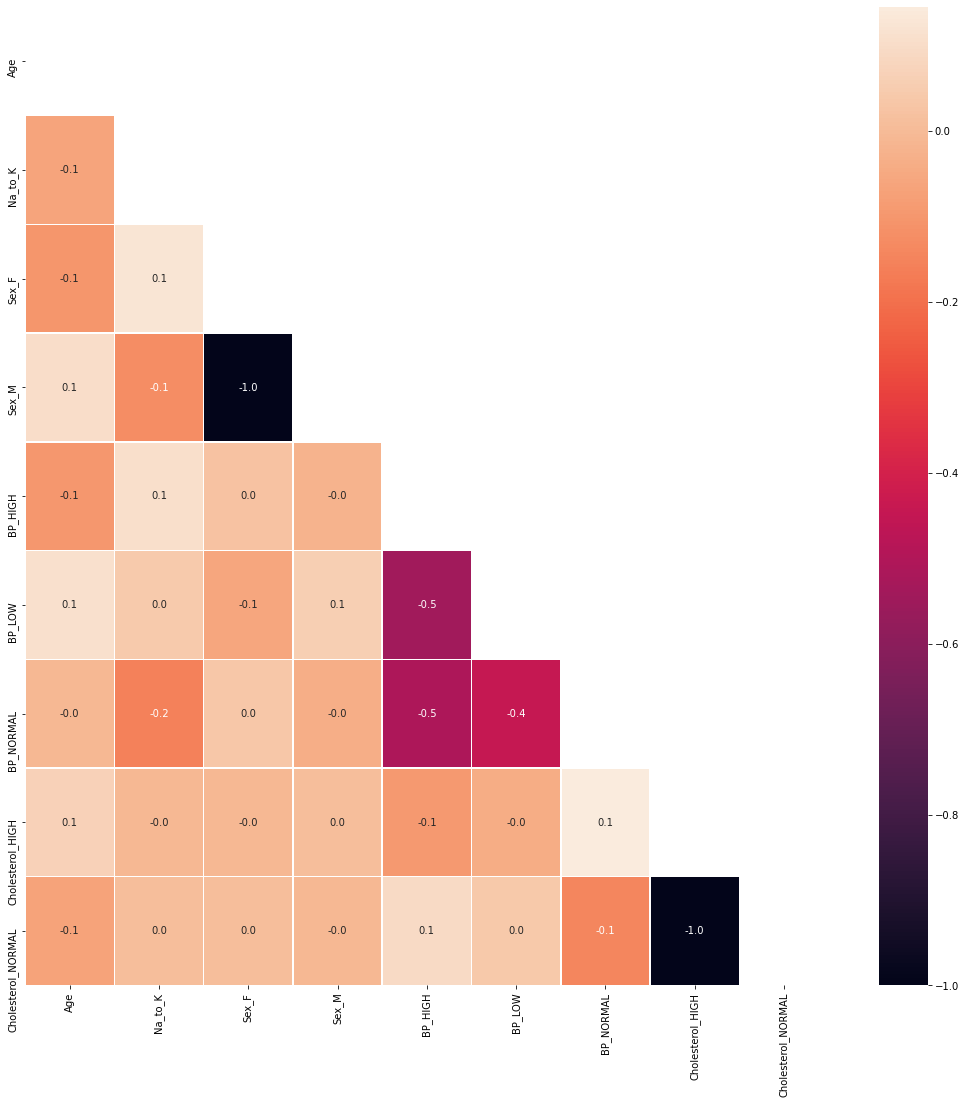

In [9]:
f,ax = plt.subplots(figsize=(18, 18))
matrix = np.triu(X.corr())
se.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, mask=matrix)
plt.show()

#### Distribution Of Target Variable

<AxesSubplot:ylabel='count'>

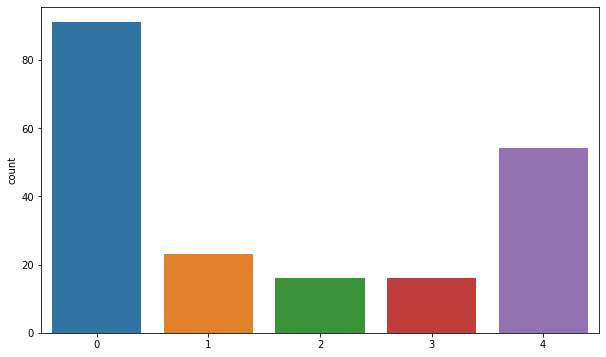

In [10]:
plt.figure(figsize = (10,6))
se.countplot(Y)

### Data Splitting

The train-test split is a procedure for evaluating the performance of an algorithm. The procedure involves taking a dataset and dividing it into two subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

### Rescaling technique

Pool is the fastest way to pass the features data to the Pool constructor (and other CatBoost, CatBoostClassifier, CatBoostRegressor methods that accept it) if most (or all) of your features are numerical is to pass it using FeaturesData class

Further details can be found at [API](https://catboost.ai/docs/concepts/python-reference_pool.html)

In [12]:
xy_train = Pool(data = x_train,
                label = y_train)

xy_test = Pool(data = x_test,
               label = y_test)

### Model

CatBoost is an algorithm for gradient boosting on decision trees. Developed by Yandex researchers and engineers, it is the successor of the MatrixNet algorithm that is widely used within the company for ranking tasks, forecasting and making recommendations

#### Tuning parameters

1. **learning_rate**:, float, default = it is defined automatically for Logloss, MultiClass & RMSE loss functions depending on the number of iterations if none of these parameters is set
>The learning rate. Used for reducing the gradient step.

2. **l2_leaf_reg**: float, default = 3.0
>Coefficient at the L2 regularization term of the cost function. Any positive value is allowed.

3. **bootstrap_type**: string, default = depends on the selected mode and processing unit
>Bootstrap type. Defines the method for sampling the weights of objects.
        * Supported methods:
        * Bayesian
        * Bernoulli
        * MVS
        * Poisson (supported for GPU only)
        * No
4. **subsample**: float, default = depends on the dataset size and the bootstrap type
>Sample rate for bagging. This parameter can be used if one of the following bootstrap types is selected:
        * Poisson
        * Bernoulli
        * MVS

For more information refer: [API](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)

In [13]:
# Build Model here
model = CatBoostClassifier(verbose=False)
model.fit(xy_train)

#### Model Accuracy

score() method return the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

In [14]:
print("Accuracy score {:.2f} %\n".format(model.score(xy_test)*100))

Accuracy score 100.00 %



#### Confusion Matrix

A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

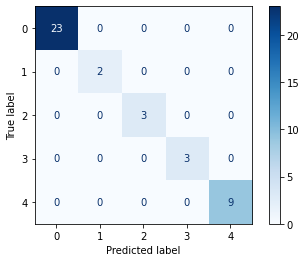

In [15]:
plot_confusion_matrix(model,xy_test,y_test,cmap=plt.cm.Blues)

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

* **where**:
    - Precision:- Accuracy of positive predictions.
    - Recall:- Fraction of positives that were correctly identified.
    - f1-score:-  percent of positive predictions were correct
    - support:- Support is the number of actual occurrences of the class in the specified dataset.

In [16]:
print(classification_report(y_test,model.predict(xy_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         9

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



 #### Creator: Viraj Jayant, Github: [Profile](https://github.com/Viraj-Jayant/)